In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_path = './real_test_images/raw/'
image_path = root_path + '/episode_0'
label_path = root_path + '/distance_0'
image_files = os.listdir(image_path)

# load distance
distance_matrix = np.load(label_path + '/distance.npy')
# remove offset 1.2m
distance_matrix = distance_matrix - 1.2
print(len(image_files))
print(len(distance_matrix))

25
25


In [3]:
def batch_maker(episode_length, image_path, num_frames):
    image_buffer = []
    _image_buffer = []    
    for i in range(episode_length):
        temp_image = cv2.imread(image_path + '/image_' + str(i) + '.jpg')      
        temp_image = cv2.resize(temp_image, (128,128), interpolation = cv2.INTER_AREA)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        _image_buffer.append(temp_image / 255.)        

    for j in range(episode_length - num_frames):
        image_buffer.append(_image_buffer[j:j + num_frames])                         
    return image_buffer

In [4]:
# batch_maker
image_buffer = batch_maker(len(image_files), image_path, num_frames=6)
# check the size of buffer
print(np.shape(image_buffer))

(19, 6, 128, 128, 3)


In [5]:
mean_velocity_matrix = []
ttc_matrix = []

shape of velocity matrix:(19,)


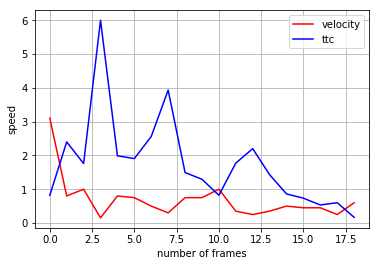

Number of image batchs:19
Number of ttc batchs:19


In [6]:
# calculate mean velocity
# time interval between images: 0.2sec
t = 0.2
for i in range(len(distance_matrix)-1):
    delta_d = abs(distance_matrix[i+1] - distance_matrix[i])
    mean_velocity = delta_d / t
    mean_velocity_matrix.append(mean_velocity)
mean_velocity_matrix = np.array(mean_velocity_matrix)
# remove the first five images
mean_velocity_matrix = mean_velocity_matrix[5:]
print('shape of velocity matrix:{}'.format(np.shape(mean_velocity_matrix)))

# calculate time to collision
distance_matrix = distance_matrix[5:len(distance_matrix)-1]
for i in range(len(mean_velocity_matrix)):
    ttc = distance_matrix[i] / mean_velocity_matrix[i]
    if ttc >= 6:
        ttc = 6.0    
    else:
        ttc = ttc
    ttc_matrix.append(ttc)
ttc_matrix = np.array(ttc_matrix)

# check result
plt.figure()    
plt.plot(np.arange(len(mean_velocity_matrix)), mean_velocity_matrix, color = 'r', label = 'velocity')
plt.plot(np.arange(len(ttc_matrix)), ttc_matrix, color = 'b', label = 'ttc')
plt.grid()
plt.xlabel('number of frames')
plt.ylabel('speed')
plt.legend(loc = 'upper right')
plt.show()

print('Number of image batchs:{}'.format(len(image_buffer)))
print('Number of ttc batchs:{}'.format(len(ttc_matrix)))

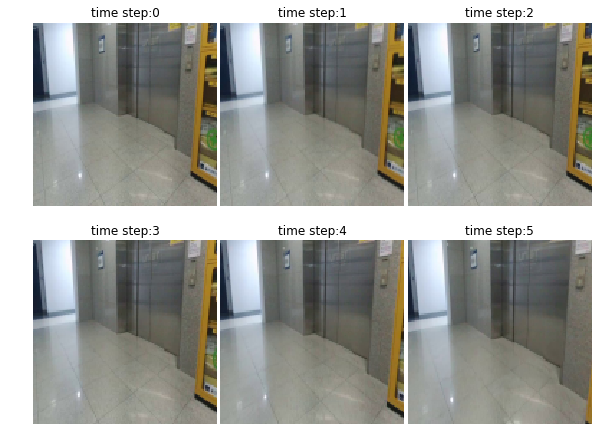

True time to collision: 2.4000020861645566
Shape of the data:(6, 128, 128, 3)
Speed:0.7999992370605469
Dsitance:1.9199998378753662


In [8]:
# visualization of training data
n = np.random.randint(len(image_buffer))
sample = image_buffer[n]

fig = plt.figure(figsize = (10,8))
for i in range(6):
    _sample = np.reshape(sample[i],[128, 128,3]) 
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(_sample)
    ax.set_title('time step:' + str(i))
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

print("True time to collision: {}".format(ttc_matrix[n]))
print("Shape of the data:{}".format(np.shape(sample)))
print("Speed:{}".format(mean_velocity_matrix[n]))
print("Dsitance:{}".format(distance_matrix[n]))

In [ ]:
# save dataset
preprocessed_root_dir = './real_test_images/preprocessed/'
np.save(preprocessed_root_dir + './episode_0/image.npy', image_buffer)
np.save(preprocessed_root_dir + './ttc/distance_0.npy', ttc_matrix)
np.save(preprocessed_root_dir + './velocity/velocity_0.npy', mean_velocity_matrix)